In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import joypy


from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
#from tqdm import tqdm_notebook
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import warnings



In [2]:
df = pd.read_csv("../data/inflatie_ro.csv")
df['Data'] = pd.to_datetime(df['Data'])
df.set_index('Data', inplace=True)

In [3]:
result = adfuller(df['Inflatie'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.819432
p-value: 0.370858


In [4]:
df['Inflatie_diff_1'] = df['Inflatie'].diff()
df.dropna(inplace=True)
result = adfuller(df['Inflatie_diff_1'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.530571
p-value: 0.000173


Text(0.5, 1.0, 'Difference 1')

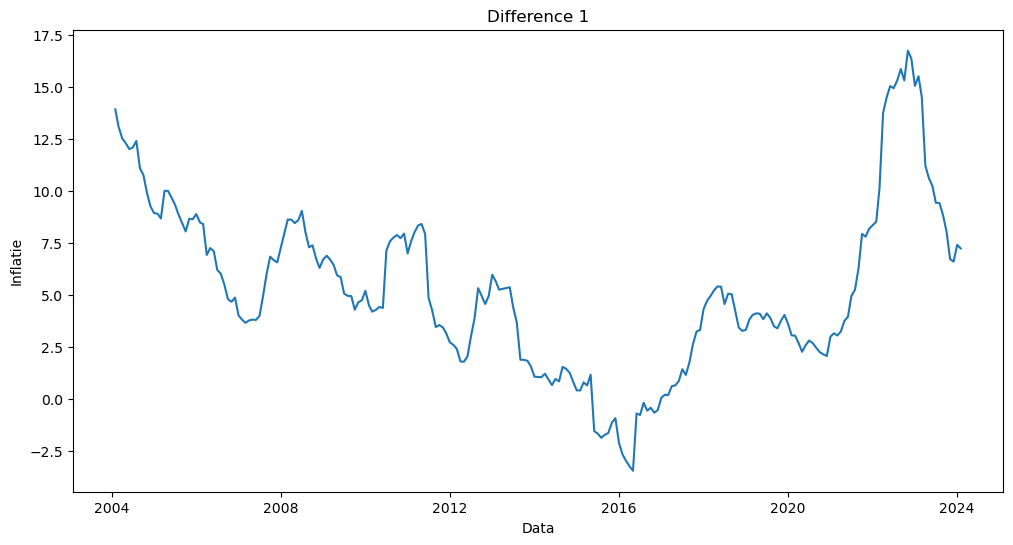

In [73]:
plt.figure(figsize=(12,6))
g = sns.lineplot(data=df, x='Data',y='Inflatie')
g.set_title('Difference 1') 


Text(0.5, 1.0, 'Difference 1')

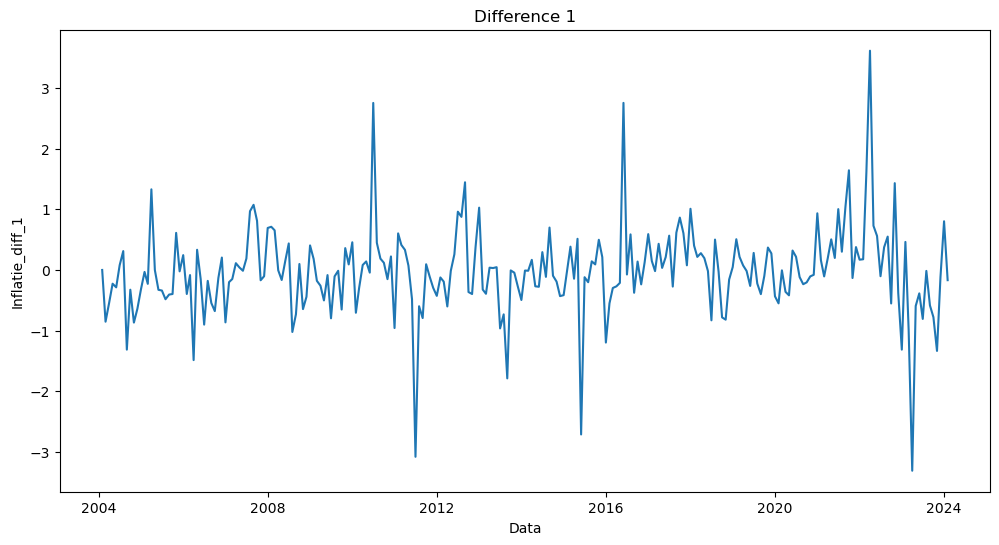

In [5]:
plt.figure(figsize=(12,6))
g = sns.lineplot(data=df, x='Data',y='Inflatie_diff_1')
g.set_title('Difference 1') 


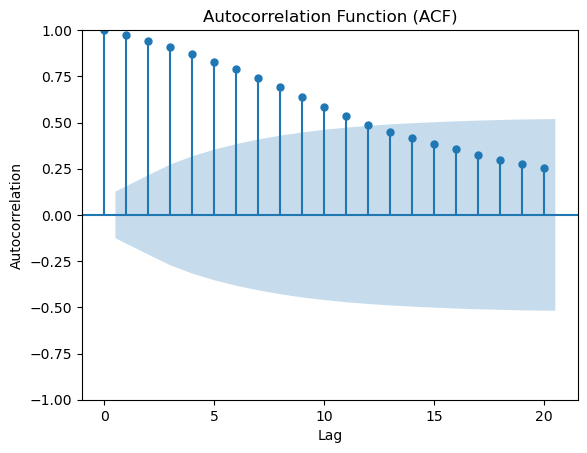

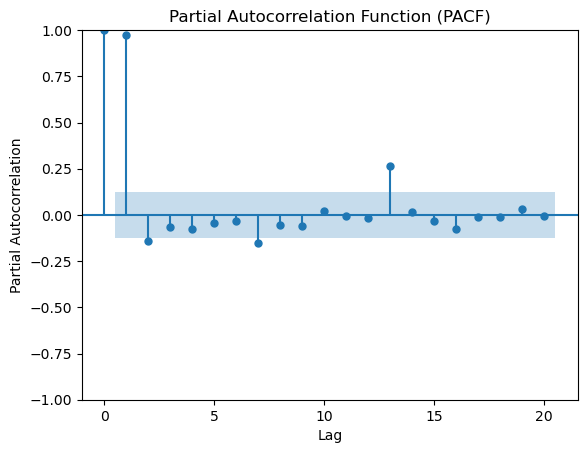

In [6]:
plot_acf(df['Inflatie'], lags=20)  # Adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plot_pacf(df['Inflatie'], lags=20)  # Adjust the number of lags as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

241

In [74]:
%%time


# Filter out the specific warning message
warnings.filterwarnings("ignore", message="No frequency information was provided*")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge*")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found*")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found*")

total_obs = len(df)
train_length = 180
forecast_length = 6
label_actual='Inflatie'



p_list = np.arange(0,14,1)
i_list = [1]
q_list = np.arange(0,14,1)

experiment_name_list = []
mape_list = []
potential_errors = []

for p in p_list:
    for i in i_list:
        for q in q_list:
            name_experiment = f"{p}_{i}_{q}"
            experiment_name_list.append(name_experiment)
            preds = []
            actual = []
            for k in range(train_length, total_obs - forecast_length + 1):
                train_data = df.iloc[k - train_length:k]
                test_data = df.iloc[k:k + forecast_length]
                
                # Train your model on train_data and make forecasts on test_data
                try:
                    model = ARIMA(train_data[label_actual], order=(p, i, q)).fit()
                    forecasts = model.forecast(forecast_length)
                    preds.extend(forecasts)
                    actual.extend(test_data[label_actual].tolist())
                    mape = mean_absolute_percentage_error(preds,actual)
                except Exception as e:
                    error_to_save = f"{name_experiment} : {e}"
                    potential_errors.append(error_to_save)
                    print(error_to_save)
                    continue
                
            mape_list.append(mape)
            count_total_experiments = len(p_list)*len(q_list)
            completed_iters = len(mape_list)
            current_progress = completed_iters/count_total_experiments * 100

            print(f"Completed: {round(current_progress,2)} %")




Completed: 0.51 %
Completed: 1.02 %
Completed: 1.53 %
Completed: 2.04 %
Completed: 2.55 %
Completed: 3.06 %
Completed: 3.57 %
Completed: 4.08 %
Completed: 4.59 %
Completed: 5.1 %
Completed: 5.61 %
Completed: 6.12 %
Completed: 6.63 %
Completed: 7.14 %
Completed: 7.65 %
Completed: 8.16 %
Completed: 8.67 %
Completed: 9.18 %
Completed: 9.69 %
Completed: 10.2 %
Completed: 10.71 %
Completed: 11.22 %
Completed: 11.73 %
Completed: 12.24 %
Completed: 12.76 %
Completed: 13.27 %
Completed: 13.78 %
Completed: 14.29 %
Completed: 14.8 %
Completed: 15.31 %
Completed: 15.82 %
Completed: 16.33 %
Completed: 16.84 %
Completed: 17.35 %
Completed: 17.86 %
Completed: 18.37 %
Completed: 18.88 %
Completed: 19.39 %
Completed: 19.9 %
Completed: 20.41 %
Completed: 20.92 %
Completed: 21.43 %
Completed: 21.94 %
Completed: 22.45 %
Completed: 22.96 %
Completed: 23.47 %
Completed: 23.98 %
Completed: 24.49 %
Completed: 25.0 %
Completed: 25.51 %
Completed: 26.02 %
Completed: 26.53 %
Completed: 27.04 %
Completed: 27.55 

In [89]:
results = pd.DataFrame({'model':experiment_name_list,
                        'mape':mape_list})

In [142]:
len(experiment_name_list) * len

196

In [90]:
results.sort_values(by='mape').head(20)

,model,mape
81,5_1_11,0.177922
66,4_1_10,0.180632
67,4_1_11,0.188654
130,9_1_4,0.188887
38,2_1_10,0.189211
52,3_1_10,0.189866
93,6_1_9,0.190830
138,9_1_12,0.194123
90,6_1_6,0.194276
186,13_1_4,0.195363


In [91]:
results.sort_values(by='mape').tail(20)

,model,mape
147,10_1_7,2.376750e-01
175,12_1_7,2.378503e-01
192,13_1_10,2.394220e-01
39,2_1_11,2.397715e-01
19,1_1_5,2.398326e-01
0,0_1_0,2.430639e-01
9,0_1_9,2.443248e-01
36,2_1_8,2.445215e-01
23,1_1_9,2.446138e-01
178,12_1_10,2.456574e-01


### Masurarea erorii pentru modelul ales

Se vor colecta erorile din fiecare punct al seriei de timp (exceptand un default de primele 180 observatii pentru train). Se antreneaza in fiecare

$t \in \{180, \ldots, 241\}$

In [97]:
%%time


# Filter out the specific warning message
warnings.filterwarnings("ignore", message="No frequency information was provided*")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge*")
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found*")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found*")

total_obs = len(df)
train_length = 180
forecast_length = 6
label_actual='Inflatie'

p = 5
i = 1
q = 11



preds = []
actual = []
for k in range(train_length, total_obs - forecast_length + 1):
    train_data = df.iloc[k - train_length:k]
    test_data = df.iloc[k:k + forecast_length]
    
    # Train your model on train_data and make forecasts on test_data
    try:
        model = ARIMA(train_data[label_actual], order=(p, i, q)).fit()
        forecasts = model.forecast(forecast_length)
        preds.extend(forecasts)
        actual.extend(test_data[label_actual].tolist())
        mape = mean_absolute_percentage_error(preds,actual)
    except Exception as e:
        error_to_save = f"t = {k}: {e}"
        # potential_errors.append(error_to_save)
        print(error_to_save)
        continue
    
#mape_list.append(mape)

results_experiment = pd.DataFrame({'actual':actual, 'predicted':preds })
results_experiment['error'] = results_experiment['actual'] - results_experiment['predicted']
results_experiment['error_percentage'] =  (1 - results_experiment['predicted']/results_experiment['actual']) *100
results_experiment['t_forecast'] = [(i % 6) + 1 for i in range(len(results_experiment))]
results_experiment['t_forecast'] = results_experiment['t_forecast'].astype('str')
results_experiment



TypeError: unsupported operand type(s) for -: 'list' and 'list'

,actual,predicted,error,error_percentage,t_forecast
0,3.824984,3.276674,0.548311,14.334980,1
1,4.040050,3.411218,0.628833,15.564976,2
2,4.114125,3.336873,0.777251,18.892267,3
3,4.097375,3.339029,0.758345,18.508074,4
4,3.833663,3.220423,0.613240,15.996194,5
...,...,...,...,...,...
331,8.059643,8.568621,-0.508978,-6.315138,2
332,6.723836,8.018209,-1.294374,-19.250530,3
333,6.604787,8.474791,-1.870003,-28.312845,4
334,7.408139,9.044674,-1.636535,-22.091045,5


Text(0.5, 1.0, 'Percentage errors for each t periods forecasted')

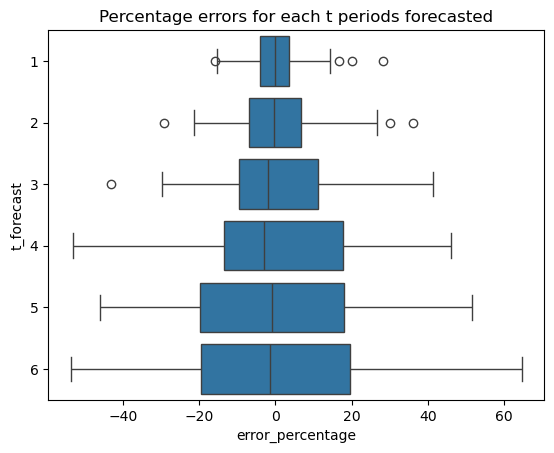

In [108]:
boxplot_errors = sns.boxplot(data=results_experiment, x='error_percentage', y='t_forecast')
boxplot_errors.set_title('Percentage errors for each t periods forecasted')

Text(0.5, 1.0, 'Percentage errors for each t periods forecasted')

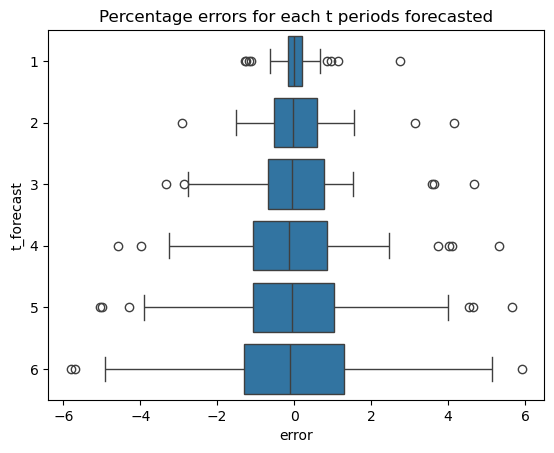

In [109]:
boxplot_errors = sns.boxplot(data=results_experiment, x='error', y='t_forecast')
boxplot_errors.set_title('Percentage errors for each t periods forecasted')

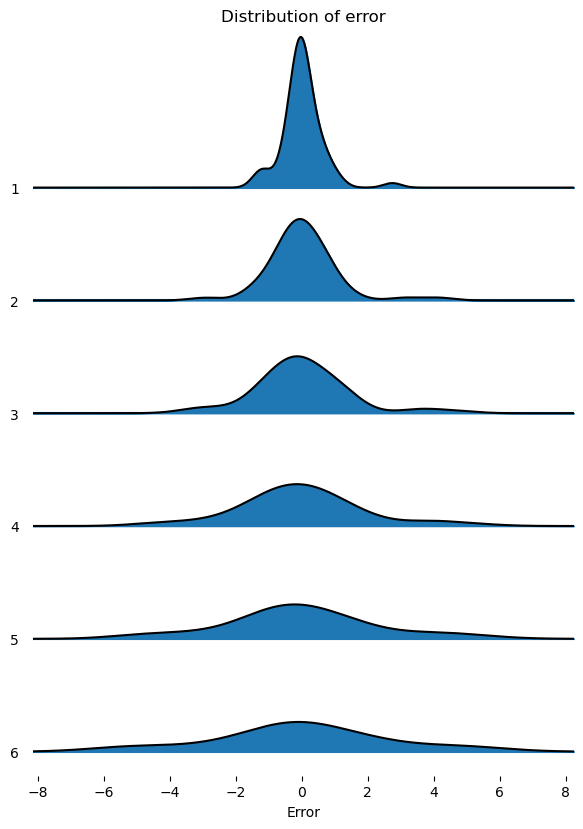

In [112]:
fig, axes = joypy.joyplot(results_experiment, by="t_forecast", column="error", figsize=(6, 8))

# Customize the plot if needed
plt.title(f"Distribution of error")
plt.xlabel("Error")
plt.ylabel("Label")
plt.show()

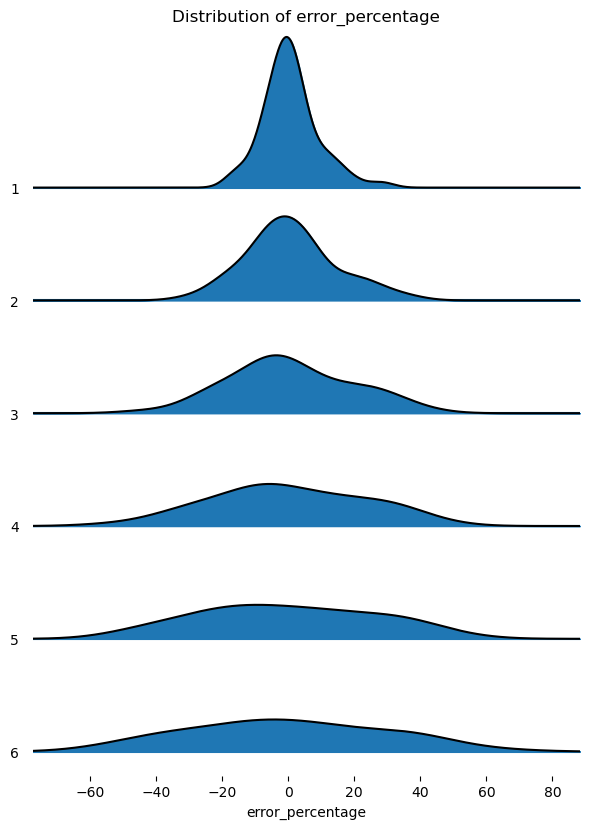

In [113]:
fig, axes = joypy.joyplot(results_experiment, by="t_forecast", column="error_percentage", figsize=(6, 8))

# Customize the plot if needed
plt.title(f"Distribution of error_percentage")
plt.xlabel("error_percentage")
plt.ylabel("t periods")
plt.show()

In [114]:
df

,Inflatie,Inflatie_diff_1
Data,,
2004-02-01,13.929717,0.000000
2004-03-01,13.076285,-0.853433
2004-04-01,12.533677,-0.542607
2004-05-01,12.306873,-0.226805
2004-06-01,12.020059,-0.286814
...,...,...
2023-10-01,8.059643,-0.778422
2023-11-01,6.723836,-1.335808
2023-12-01,6.604787,-0.119048


In [117]:
end_train = '2020-01-01'

temp_train = df[df.index <= end_train]
temp_test = df[df.index>end_train][0:forecast_length]
temp_test

,Inflatie,Inflatie_diff_1
Data,,
2020-02-01,3.051407,-0.550970
2020-03-01,3.044733,-0.006674
2020-04-01,2.683738,-0.360995
2020-05-01,2.265161,-0.418577
2020-06-01,2.585645,0.320484
2020-07-01,2.803129,0.217484


In [118]:
#functii
def plot_train_test(data_train: pd.DataFrame, data_test:pd.DataFrame, actual:str, predicted:str):
    plt.figure(figsize=(12,6))
    # Plot y1 and y2 from df1 with specified colors
    plt.plot(data_train.index[1:], data_train[actual][1:], color='blue', label=actual)
    plt.plot(data_train.index[1:], data_train[predicted][1:], color='orange', label=f'{predicted} in sample')

    # Plot y1 from df2 with specified color
    plt.plot(data_test.index, data_test[actual], color='blue', label='')

    # Plot y2 from df2 with specified color and label
    plt.plot(data_test.index, data_test[predicted], color='red', label=f'{predicted} out of sample')

    

    # Set the title and labels
    plt.title('In sample vs out of sample prediction')
    plt.xlabel('Date')
    plt.ylabel('Values')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()


def train_and_plot(dataset:pd.DataFrame, data_train_end:str,p:int, i:int,q:int, actual:str,forecast_length:int, plot=True, summary=True):
    data_train = dataset[dataset.index <= data_train_end]
    data_test = df[df.index>data_train_end][0:forecast_length]

    model = ARIMA(data_train[actual], order=(p, i, q)).fit()
    if summary:
        print((model.summary()))
    label = f"ARIMA_{p}_{i}_{q}"
    data_train[label] = model.fittedvalues
    data_test[label] = model.forecast(forecast_length+1)
    if plot:
        plot_train_test(data_train=data_train, data_test=data_test, actual=actual,predicted=label)
    mape = mean_absolute_percentage_error(data_test[label],data_test[actual])
    return mape
    


    

Text(0.5, 1.0, 'Difference 1')

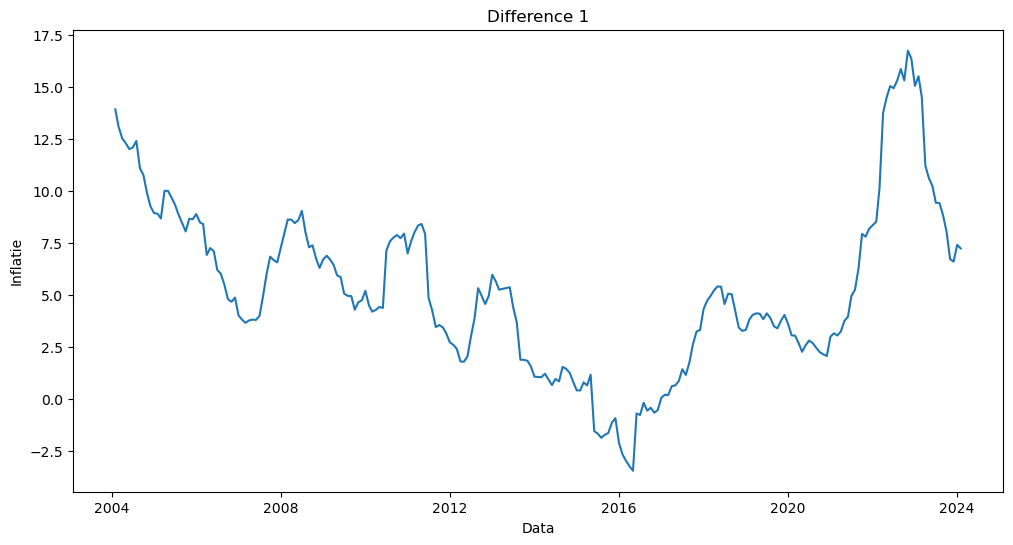

In [119]:
plt.figure(figsize=(12,6))
g = sns.lineplot(data=df, x='Data',y='Inflatie')
g.set_title('Difference 1') 


                               SARIMAX Results                                
Dep. Variable:               Inflatie   No. Observations:                  212
Model:                ARIMA(5, 1, 11)   Log Likelihood                -140.912
Date:                Thu, 25 Apr 2024   AIC                            315.823
Time:                        20:55:33   BIC                            372.805
Sample:                    02-01-2004   HQIC                           338.856
                         - 09-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7535      0.107     -7.018      0.000      -0.964      -0.543
ar.L2         -0.5321      0.127     -4.183      0.000      -0.781      -0.283
ar.L3         -0.4540      0.123     -3.686      0.0

C:\Users\octav\AppData\Local\Temp\ipykernel_29848\856674181.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[label] = model.fittedvalues


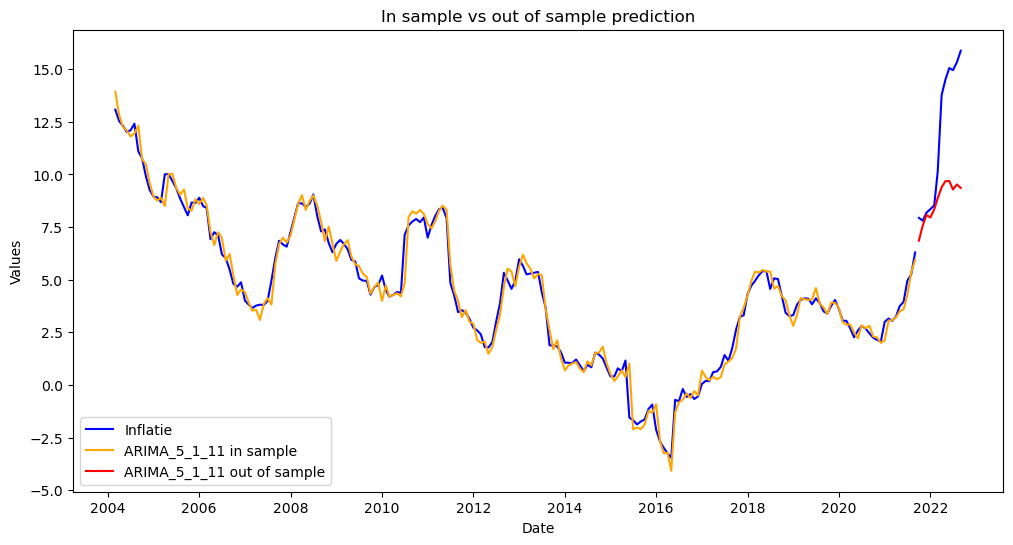

0.3210008371533714

In [145]:
p = 5
q = 11

train_and_plot(dataset=df, data_train_end='2021-09-01',p=p,i=1,q=q,actual='Inflatie',forecast_length=12)

In [120]:
df[0:180]

,Inflatie,Inflatie_diff_1
Data,,
2004-02-01,13.929717,0.000000
2004-03-01,13.076285,-0.853433
2004-04-01,12.533677,-0.542607
2004-05-01,12.306873,-0.226805
2004-06-01,12.020059,-0.286814
...,...,...
2018-09-01,5.031704,-0.030728
2018-10-01,4.249195,-0.782509
2018-11-01,3.429158,-0.820037


In [151]:
std_dev_t = results_experiment.groupby('t_forecast').agg({'error':'std'})
std_dev_t_dict = std_dev_t.to_dict()['error']
std_dev_t_dict

{'1': 0.6119140926827071,
 '2': 1.036788777442977,
 '3': 1.4097785893368269,
 '4': 1.847705443486122,
 '5': 2.248344333184526,
 '6': 2.58895932829578}

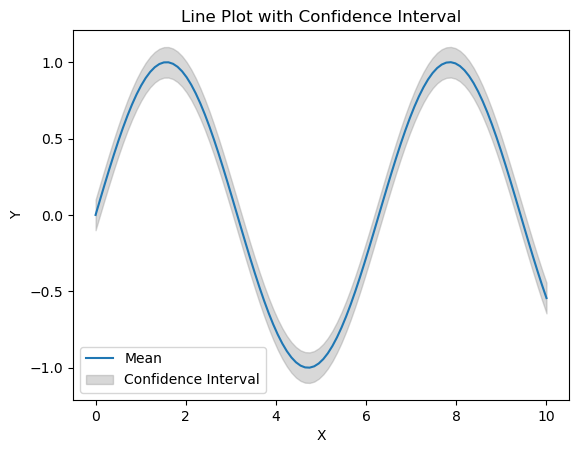

In [152]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data
x = np.linspace(0, 10, 100)
y = np.sin(x)
# Define the standard deviation or confidence interval
confidence_interval = 0.1

# Calculate upper and lower bounds for the confidence interval
upper_bound = y + confidence_interval
lower_bound = y - confidence_interval

# Plot the line
plt.plot(x, y, label='Mean')

# Plot the confidence interval
plt.fill_between(x, lower_bound, upper_bound, color='gray', alpha=0.3, label='Confidence Interval')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Line Plot with Confidence Interval')
plt.legend()

# Show the plot
plt.show()


In [ ]:
#functii
def plot_train_test_interval(data_train: pd.DataFrame, data_test:pd.DataFrame, actual:str, predicted:str,std_list:dict):
    plt.figure(figsize=(12,6))
    # Plot y1 and y2 from df1 with specified colors
    plt.plot(data_train.index[1:], data_train[actual][1:], color='blue', label=actual)
    plt.plot(data_train.index[1:], data_train[predicted][1:], color='orange', label=f'{predicted} in sample')
    
    # Plot y1 from df2 with specified color
    plt.plot(data_test.index, data_test[actual], color='blue', label='')

    # Plot y2 from df2 with specified color and label
    plt.plot(data_test.index, data_test[predicted], color='red', label=f'{predicted} out of sample')

    

    # Set the title and labels
    plt.title('In sample vs out of sample prediction')
    plt.xlabel('Date')
    plt.ylabel('Values')

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()


def train_and_plot(dataset:pd.DataFrame, data_train_end:str,p:int, i:int,q:int, actual:str,forecast_length:int, plot=True, summary=True):
    data_train = dataset[dataset.index <= data_train_end]
    data_test = df[df.index>data_train_end][0:forecast_length]

    model = ARIMA(data_train[actual], order=(p, i, q)).fit()
    if summary:
        print((model.summary()))
    label = f"ARIMA_{p}_{i}_{q}"
    data_train[label] = model.fittedvalues
    data_test[label] = model.forecast(forecast_length+1)
    if plot:
        plot_train_test(data_train=data_train, data_test=data_test, actual=actual,predicted=label)
    mape = mean_absolute_percentage_error(data_test[label],data_test[actual])
    return mape
    


    

In [154]:
df_copy = df.copy()

model_5_1_11 = ARIMA(df_copy['Inflatie'], order=(5, 1, 11)).fit()

model_5_1_11.forecast(6)

2024-03-01    7.254170
2024-04-01    7.732598
2024-05-01    7.790433
2024-06-01    7.386597
2024-07-01    7.471104
2024-08-01    6.839296
Freq: MS, Name: predicted_mean, dtype: float64

In [160]:
predictions = pd.DataFrame(model_5_1_11.forecast(6))

predictions['std'] = std_dev_t_dict.values()
predictions['lower_bund'] = predictions['predicted_mean'] - 1.96*predictions['std']
predictions['upper_bund'] = predictions['predicted_mean'] + 1.96*predictions['std']
predictions

,predicted_mean,std,lower_bund,upper_bund
2024-03-01,7.254170,0.611914,6.054818,8.453522
2024-04-01,7.732598,1.036789,5.700492,9.764704
2024-05-01,7.790433,1.409779,5.027267,10.553599
2024-06-01,7.386597,1.847705,3.765094,11.008100
2024-07-01,7.471104,2.248344,3.064350,11.877859
2024-08-01,6.839296,2.588959,1.764936,11.913656


In [164]:
df_forecasts = pd.concat([df_copy,predictions])

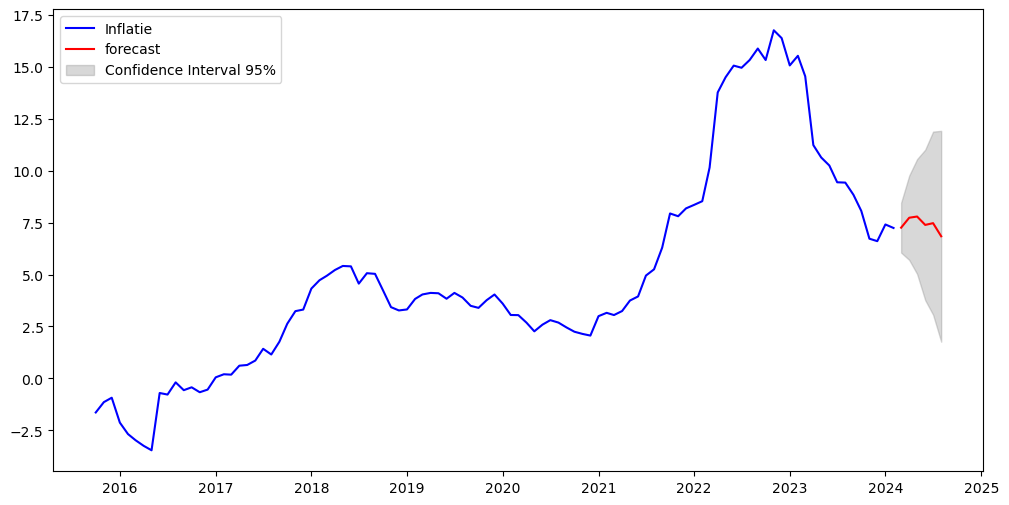

In [174]:
plt.figure(figsize=(12,6))
# Plot y1 and y2 from df1 with specified colors
plt.plot(df_forecasts.index[140:], df_forecasts['Inflatie'][140:], color='blue', label='Inflatie')
#plt.plot(df_forecasts.index[1:], df_forecasts['predicted_mean'][1:], color='orange', label=f'{predicted')

# Plot y1 from df2 with specified color
plt.plot(df_forecasts[-6:].index, df_forecasts[-6:]['predicted_mean'], color='red', label='forecast')

# Plot the confidence interval
plt.fill_between(df_forecasts[-6:].index, df_forecasts[-6:]['lower_bund'],
                  df_forecasts[-6:]['upper_bund'], color='gray', alpha=0.3, label='Confidence Interval 95%')

# Plot y2 from df2 with specified color and label
#plt.plot(data_test.index, data_test[predicted], color='red', label=f'{predicted} out of sample')

plt.legend()

# Show the plot
plt.show()
